### Important
This code is used to plot the weather regimes, and also to remap the (random) clustering order from `01_WR_clustering_Bayes.py` to a standardised output, used in the rest of the scripts. This has to be manually adapted below via CLUSTER_REMAPPING to match the order given by CLUSTER_NAMES in `config.py`

### 1. Preliminaries

In [1]:
import ast
import os
from datetime import datetime

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from config import PATH_CLUSTERS, THRES, VERSION, CLUSTER_NAMES

In [2]:
centroids_real_space_raw = xr.open_dataarray(os.path.join(PATH_CLUSTERS, VERSION,
                                                      "centroids_unordered.nc"))
lons = centroids_real_space_raw.lon.to_numpy()
lats = centroids_real_space_raw.lat.to_numpy()
df_cluster = pd.read_csv(os.path.join(PATH_CLUSTERS, VERSION, "df_clusters_full_unordered.csv"))
df_cluster["time"] = pd.to_datetime(df_cluster["time"])

### 2. Defining Functions

In [3]:
def plot_clusters(df, centroids_real_space, z500_clim, lons, lats, ordered = True):
    """Plot zg500 clusters on a map.

    Parameters
    ----------
    - centroids_real_space: Transformed cluster centers.
    - lons, lats: Longitude and Latitude values.

    """
    n_clusters = centroids_real_space.shape[0]
    levels_z500 = np.arange(5000, 6000, 80)

    fig, axs = plt.subplots(2, 2, figsize=(9, 6),
                            subplot_kw={"projection": ccrs.LambertConformal(central_longitude=-30, central_latitude=50)})

    axs = axs.flatten()
    if ordered:
        titles = CLUSTER_NAMES
    else:
        titles = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"]

    percentages = df['Bayes_cluster'].value_counts(normalize = True, sort = False).sort_index().to_list()
    for i, ax in enumerate(axs):
        if i < n_clusters:
            ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()],
                          crs=ccrs.PlateCarree())
            fill = ax.contourf(
                lons,
                lats,
                centroids_real_space[i, :, :].squeeze(),
                levels=np.linspace(-200, 200, 21),
                cmap=plt.cm.RdBu_r,
                extend="both",
                transform=ccrs.PlateCarree())
            CS = ax.contour(
                lons,
                lats,
                centroids_real_space[i, :, :].squeeze() + z500_clim,
                levels=levels_z500,
                colors="k",
                linewidths=1,
                transform=ccrs.PlateCarree())
            ax.clabel(CS, inline=True, fontsize=10)
            ax.coastlines(resolution="50m")
            ax.gridlines()
            ax.set_title(f"{titles[i]} ({100 * percentages[i]:.2f}%)", fontsize=12)

    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
    cb = fig.colorbar(fill, cax=cbar_ax, orientation="vertical", label="500 hPa height anomaly [m]", extend="both", ticks=np.arange(-200, 250, 50))


In [4]:
def plot_bayes(df_cluster, year, run):
    """Plot timeseries of Bayes parameters, make hard assignment."""
    date_begin = datetime(year - 1, 11, 1, 9)  # November 1st of the season_begin year
    date_end = datetime(year, 3, 31, 9)  # March 31st of the year

    # Perform the query and get the DataFrame
    tbegin = df_cluster.query("run == @run and time >= @date_begin").index.min()
    tend = df_cluster.query("run == @run and time <= @date_end").index.max()

    cluster_subset = df_cluster.loc[tbegin:tend]

    time = cluster_subset["time"]
    prior = np.array(cluster_subset["prior"].apply(ast.literal_eval).tolist())
    likelihood = np.array(cluster_subset["likelihood"].apply(ast.literal_eval).tolist())
    post = np.array(cluster_subset["posterior"].apply(ast.literal_eval).tolist())
    hard_assignment = cluster_subset["Bayes_cluster"].to_numpy()
    original_clusters = cluster_subset["cluster_id"].to_numpy()

    fig, axs = plt.subplots(
        5,
        1,
        sharex=True,
        figsize=(8, 10),
        gridspec_kw={"height_ratios": [3, 3, 3, 0.1, 0.1]},
    )

    for i, cluster in enumerate(CLUSTER_NAMES):
        axs[0].plot(time, prior[:, i], label=cluster)
        axs[1].plot(time, likelihood[:, i], label=cluster)
        axs[2].plot(time, post[:, i], label=cluster)
    
    axs[0].set_ylabel("Prior")
    axs[1].set_ylabel("Likelihood")
    axs[2].set_ylabel("Posterior")
    axs[2].axhline(y=THRES, color="gray", linestyle="--", label="Threshold")

    # Add 'hard assignment' plot with colored dots
    colors = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:gray",
    ] 
    hard_assignment_color = [
        colors[hard_assignment[idx]]
        for idx in range(len(hard_assignment))
    ]
    original_clusters_color = [
        colors[original_clusters[idx]]
        for idx in range(len(original_clusters))
    ]

    # Add 'hard assignment' plot with colored bar charts
    bar_height = 0.2
    for t, color in zip(time, hard_assignment_color):
        axs[3].bar(t, bar_height, color=color, width=1, align="center")
    for t, color in zip(time, original_clusters_color):
        axs[4].bar(t, bar_height, color=color, width=1, align="center")

    axs[3].set_ylim(0, bar_height)  # Set the y-axis limits to match the bar height
    axs[3].set_yticks([])  # Hide y-axis ticks for consistent height
    axs[3].set_ylabel("Hard")

    axs[4].set_ylim(0, bar_height)  # Set the y-axis limits to match the bar height
    axs[4].set_yticks([])  # Hide y-axis ticks for consistent height
    axs[4].set_ylabel("Def.")

    axs[0].legend(loc="upper right")  # Adjust the location of the overall legend
    plt.tight_layout()

### 3. Plotting

In [5]:
z500 = xr.open_dataarray("/usr/people/duinen/MSc-thesis/Data/clim_zg500_v1.nc")
z500 = z500.where(
        (z500["lon"] < 30) &
        (z500["lat"] > 20) &
        (z500["lat"] < 80) &
        ((z500["dayofyear"] > 304) | (z500["dayofyear"] < 91)),
)

z500 = z500.sel(lon=slice(None, 30), lat=slice(20, 80))
z500_coarse = z500.coarsen(lon = 3).mean().coarsen(lat = 3, boundary = "trim").mean()
z500_clim = z500_coarse.mean(dim = "dayofyear", skipna = True)

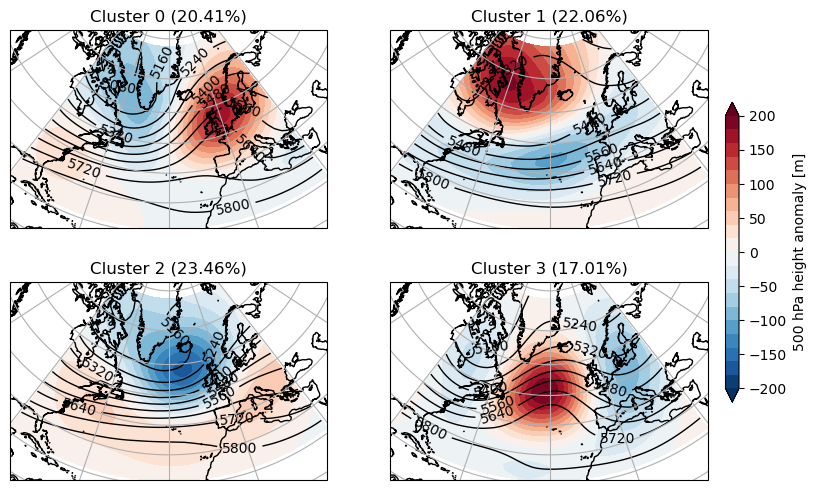

In [6]:
#TODO: isobars should really be calculated and shown for each day; now anomaly wrt average over whole winter. Thats not right
plot_clusters(df_cluster, centroids_real_space_raw, z500_clim, lons, lats, ordered = False)

In [7]:
CLUSTER_REMAPPING = {0: 2, 1: 1, 2: 0, 3: 3, 4: 4} # make sure to change after new clustering run!
df_cluster['Bayes_cluster'] = df_cluster['Bayes_cluster'].map(CLUSTER_REMAPPING)
df_cluster['Bayes_cluster_raw'] = df_cluster['Bayes_cluster_raw'].map(CLUSTER_REMAPPING)
df_cluster['cluster_id'] = df_cluster['cluster_id'].map(CLUSTER_REMAPPING)
centroids_real_space = centroids_real_space_raw[list(CLUSTER_REMAPPING.values())[:4], :, :]

df_cluster.to_csv(os.path.join(PATH_CLUSTERS, VERSION, "df_clusters_full_ordered.csv"))
centroids_real_space.to_netcdf(os.path.join(PATH_CLUSTERS, VERSION, "centroids_ordered.nc"))

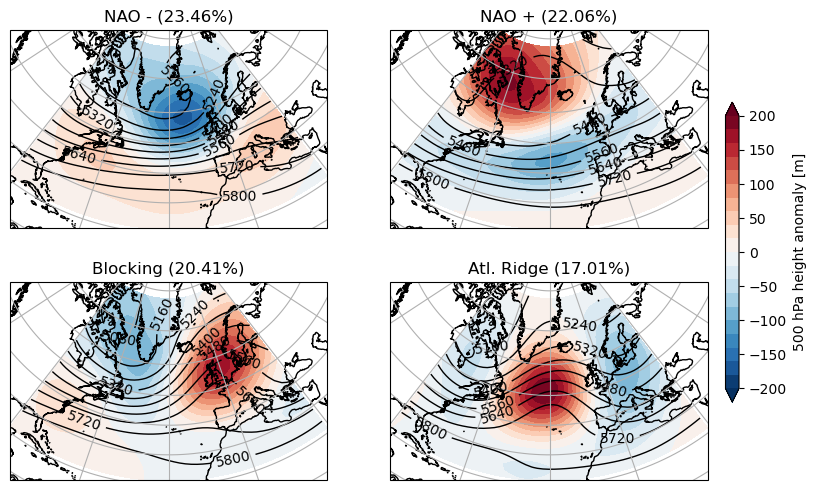

In [8]:
plot_clusters(df_cluster, centroids_real_space, z500_clim, lons, lats, ordered = True)

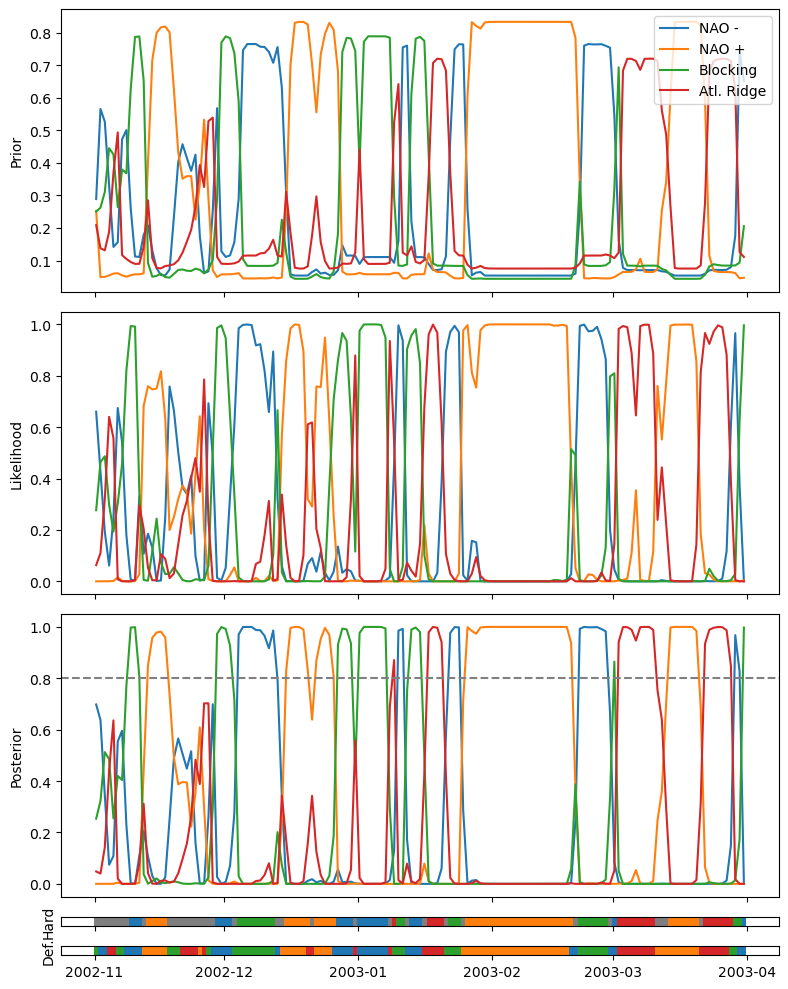

In [9]:
plot_bayes(df_cluster, 2003, 10)